# Transfer Learning: Fine Tune, Funtional API

In [ ]:
# FineTuning Model
cnn_base.trainable = True

set_trainable = False

for layer in cnn_base.layers:
  if layer.name =='block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in cnn_base.layers:
  print(layer.name, layer.trainable)

# **The CIFAR-100 dataset**

In [ ]:
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model # Functional API
from keras.models import Sequential # Sequential API
from keras.layers import *
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import to_categorical, img_to_array, array_to_img, load_img
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode="fine")

169001437/169001437 [==============================] - 3s 0us/step


In [ ]:
(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

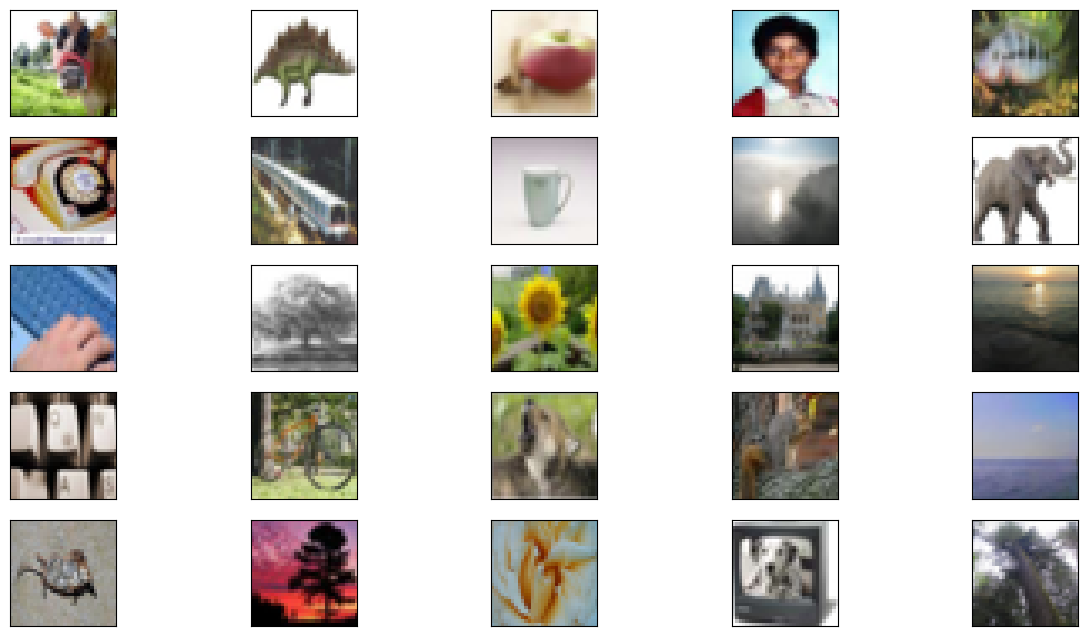

In [ ]:
plt.figure(figsize=(15,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()

In [ ]:
# Parse numbers as floats
x_train= x_train.astype('float32')
x_test= x_test.astype('float32')

In [ ]:
# normalization
X_train = (x_train) / 255.
X_test = (x_test) / 255.

In [ ]:
# number of classes
nb_classes = len(np.unique(y_train))
nb_classes

100

In [ ]:
# Image size
img_width, img_height, img_num_channels = 32, 32, 3
input_shape = (img_width, img_height, img_num_channels)
input_shape

(32, 32, 3)

In [ ]:
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

# EfficientNetV2L

In [ ]:
from keras.applications import EfficientNetV2L

In [ ]:
conv_model = EfficientNetV2L(include_top=False, weights='imagenet', input_shape=(32,32,3))

473176280/473176280 [==============================] - 9s 0us/step


In [ ]:
conv_model.summary()

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 16, 16, 32)           864       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 16, 16, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                

In [ ]:
model = Sequential()
model.add(conv_model) # CNN
model.add(Flatten()) # Flatten (2D to 1D)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Function  (None, 1, 1, 1280)        117746848 
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               12900     
                                                                 
Total params: 117923716 (449.84 MB)
Trainable params: 117411140 (447.89 MB)
Non-trainable params: 512576 (1.96 MB)
_______

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', verbose=1, patience=8, restore_best_weights = True)

In [ ]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

Data augmentation

In [ ]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), batch_size=64, epochs=500, validation_data=(x_test, y_test),callbacks=callback)

Epoch 1/500
782/782 [==============================] - 402s 272ms/step - loss: 3.3669 - accuracy: 0.1758 - val_loss: 2.6222 - val_accuracy: 0.3041
Epoch 2/500
782/782 [==============================] - 194s 248ms/step - loss: 2.5929 - accuracy: 0.3204 - val_loss: 2.6298 - val_accuracy: 0.3390
Epoch 3/500
782/782 [==============================] - 192s 245ms/step - loss: 2.4833 - accuracy: 0.3488 - val_loss: 2.4104 - val_accuracy: 0.3690
Epoch 4/500
782/782 [==============================] - 196s 250ms/step - loss: 2.3758 - accuracy: 0.3703 - val_loss: 2.0728 - val_accuracy: 0.4423
Epoch 5/500
782/782 [==============================] - 192s 246ms/step - loss: 2.0749 - accuracy: 0.4335 - val_loss: 2.6932 - val_accuracy: 0.3819
Epoch 6/500
782/782 [==============================] - 191s 245ms/step - loss: 2.2100 - accuracy: 0.4077 - val_loss: 2.3020 - val_accuracy: 0.4131
Epoch 7/500
782/782 [==============================] - 191s 244ms/step - loss: 2.0550 - accuracy: 0.4438 - val_loss: 2